In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [10]:
df_rm = pd.read_csv('../data/04_GameSpy_FinalDataset.csv', index_col=0)
df_rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16538 entries, 0 to 16537
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            16538 non-null  object 
 1   Platform                        16538 non-null  object 
 2   Year                            16538 non-null  int64  
 3   Genre                           16538 non-null  object 
 4   Publisher                       16538 non-null  object 
 5   Studio                          16538 non-null  object 
 6   NA_Sales                        16538 non-null  float64
 7   EU_Sales                        16538 non-null  float64
 8   JP_Sales                        16538 non-null  float64
 9   Other_Sales                     16538 non-null  float64
 10  Global_Sales                    16538 non-null  float64
 11  GK_licence                      16538 non-null  object 
 12  Mois                            

# MODELISATION - CLASSIFICATION

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## 4 catégories

In [11]:
df_rm_tosplit = df_rm

In [12]:
#Création de 4 catégories de vente en fonction de paliers de vente spécifiques
df_rm_tosplit['Sales_cat'] = pd.cut(df_rm_tosplit['Global_Sales'], bins=[0,0.1,0.249,1, 100000], 
       labels=[1,2,3,4])
df_rm_tosplit['Sales_cat'] = df_rm_tosplit['Sales_cat'].astype("int")

#Suppression des colonnes à présent inutiles
df_rm_tosplit = df_rm_tosplit.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)

#Labelisation des variables catégorielles
cat_cols = df_rm_tosplit.select_dtypes(include=['object']).columns.to_list()
for col in cat_cols:
    i = 1
    occurences = df_rm_tosplit[col].unique()
    for occ in occurences:
        df_rm_tosplit.loc[df_rm_tosplit[col]==occ, col] = i
        i+=1
        
df_rm_tosplit[cat_cols] = df_rm_tosplit[cat_cols].astype('float')
df_rm_tosplit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16538 entries, 0 to 16537
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Platform                        16538 non-null  float64
 1   Year                            16538 non-null  int64  
 2   Genre                           16538 non-null  float64
 3   Publisher                       16538 non-null  float64
 4   Studio                          16538 non-null  float64
 5   GK_licence                      16538 non-null  float64
 6   Mois                            16538 non-null  int64  
 7   Date_Sortie                     16538 non-null  float64
 8   RM_Publisher                    16516 non-null  float64
 9   RM_Publisher_score              14347 non-null  float64
 10  RM_Publisher_rate               14347 non-null  float64
 11  RM_Publisher_reviews            13076 non-null  float64
 12  RM_Studio                       

In [13]:
#Création d'une liste pour les moyennes mobiles des notes joueurs par publisher
rm_publisher_score=[]

#Boucle qui parcourt les dates de lancement et les moyennes mobiles des notes joueurs par publisher
#et qui va attribuer aux moyennes mobiles vides, la moyenne des moyennes mobiles 
#des jeux avec une date antérieure au jeu en question. 
#Cela pour ne pas biaiser les chiffres avec des moyennes de jeux futurs.
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Publisher_score"]):
    if str(rm)=="nan":
        rm_publisher_score.append(df_rm_tosplit["RM_Publisher_score"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_publisher_score.append(rm)
        
#Même processus que précédemment sur les moyennes mobiles des notes joueurs par studio cette fois
rm_studio_score=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Studio_score"]):
    if str(rm)=="nan":
        rm_studio_score.append(df_rm_tosplit["RM_Studio_score"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_studio_score.append(rm)

#Même processus que précédemment sur les moyennes mobiles des notes joueurs par licence cette fois
rm_licence_score=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Licence_score"]):
    if str(rm)=="nan":
        rm_licence_score.append(df_rm_tosplit["RM_Licence_score"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_licence_score.append(rm)

#Remplacement des colonnes moyennes mobiles sur les notes joueurs par les listes créées traitant les valeurs vides 
df_rm_tosplit["RM_Publisher_score"]=rm_publisher_score
df_rm_tosplit["RM_Studio_score"]=rm_studio_score
df_rm_tosplit["RM_Licence_score"]=rm_licence_score

In [14]:
#Même processus que précédemment sur les moyennes mobiles des notes jounalistes cette fois par publisher
rm_publisher_rate=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Publisher_rate"]):
    if str(rm)=="nan":
        rm_publisher_rate.append(df_rm_tosplit["RM_Publisher_rate"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_publisher_rate.append(rm)
        
#Même processus que précédemment sur les moyennes mobiles des notes jounalistes cette fois par studio
rm_studio_rate=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Studio_rate"]):
    if str(rm)=="nan":
        rm_studio_rate.append(df_rm_tosplit["RM_Studio_rate"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_studio_rate.append(rm)

#Même processus que précédemment sur les moyennes mobiles des notes jounalistes cette fois par licence
rm_licence_rate=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Licence_rate"]):
    if str(rm)=="nan":
        rm_licence_rate.append(df_rm_tosplit["RM_Licence_rate"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_licence_rate.append(rm)

#Remplacement des colonnes moyennes mobiles sur les notes journalistes par les listes créées traitant les valeurs vides 
df_rm_tosplit["RM_Publisher_rate"]=rm_publisher_rate
df_rm_tosplit["RM_Studio_rate"]=rm_studio_rate
df_rm_tosplit["RM_Licence_rate"]=rm_licence_rate

In [15]:
#Même processus que précédemment sur les moyennes mobiles du nombre d'avis cette fois par publisher
rm_publisher_review=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Publisher_reviews"]):
    if str(rm)=="nan":
        rm_publisher_review.append(df_rm_tosplit["RM_Publisher_reviews"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_publisher_review.append(rm)
        
#Même processus que précédemment sur les moyennes mobiles du nombre d'avis cette fois par studio
rm_studio_review=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Studio_reviews"]):
    if str(rm)=="nan":
        rm_studio_review.append(df_rm_tosplit["RM_Studio_reviews"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_studio_review.append(rm)

#Même processus que précédemment sur les moyennes mobiles du nombre d'avis cette fois par licence
rm_licence_review=[]
for date,rm in zip(df_rm_tosplit["Date_Sortie"],df_rm_tosplit["RM_Licence_reviews"]):
    if str(rm)=="nan":
        rm_licence_review.append(df_rm_tosplit["RM_Licence_reviews"][df_rm_tosplit["Date_Sortie"]<date].mean())
    else:
        rm_licence_review.append(rm)

#Remplacement des colonnes moyennes mobiles sur le nombre d'avis par les listes créées traitant les valeurs vides 
df_rm_tosplit["RM_Publisher_reviews"]=rm_publisher_review
df_rm_tosplit["RM_Studio_reviews"]=rm_studio_review
df_rm_tosplit["RM_Licence_reviews"]=rm_licence_review

In [16]:
#Vérification du nombre de NaNs restants
df_rm_tosplit.isna().sum()

Platform                           0
Year                               0
Genre                              0
Publisher                          0
Studio                             0
GK_licence                         0
Mois                               0
Date_Sortie                        0
RM_Publisher                      22
RM_Publisher_score                 1
RM_Publisher_rate                  1
RM_Publisher_reviews               8
RM_Studio                         22
RM_Studio_score                    1
RM_Studio_rate                     1
RM_Studio_reviews                  8
RM_Licence                        22
RM_Licence_score                   1
RM_Licence_rate                    1
RM_Licence_reviews                 8
is_serie                           0
is_top_serie                       0
is_top_studio                      0
is_e3                              0
is_launch_plateform_associated     0
Sales_cat                          0
dtype: int64

In [17]:
#Suppression des derniers NaNs
df_rm_tosplit=df_rm_tosplit.dropna()

In [18]:
#Vérification des NaNs
df_rm_tosplit.isna().sum()

Platform                          0
Year                              0
Genre                             0
Publisher                         0
Studio                            0
GK_licence                        0
Mois                              0
Date_Sortie                       0
RM_Publisher                      0
RM_Publisher_score                0
RM_Publisher_rate                 0
RM_Publisher_reviews              0
RM_Studio                         0
RM_Studio_score                   0
RM_Studio_rate                    0
RM_Studio_reviews                 0
RM_Licence                        0
RM_Licence_score                  0
RM_Licence_rate                   0
RM_Licence_reviews                0
is_serie                          0
is_top_serie                      0
is_top_studio                     0
is_e3                             0
is_launch_plateform_associated    0
Sales_cat                         0
dtype: int64

In [19]:
#Suppression de la colonne avec les dates de lancement des jeux, pas utile pour la suite
df_rm_tosplit=df_rm_tosplit.drop("Date_Sortie",axis=1)

In [20]:
#Split du dataset en groupe d'entrainement et groupe de test
target=df_rm_tosplit["Sales_cat"]
data=df_rm_tosplit.drop("Sales_cat",axis=1)

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2)

In [21]:
#Vérification du format des features
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3302 entries, 14068 to 11800
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Platform                        3302 non-null   float64
 1   Year                            3302 non-null   int64  
 2   Genre                           3302 non-null   float64
 3   Publisher                       3302 non-null   float64
 4   Studio                          3302 non-null   float64
 5   GK_licence                      3302 non-null   float64
 6   Mois                            3302 non-null   int64  
 7   RM_Publisher                    3302 non-null   float64
 8   RM_Publisher_score              3302 non-null   float64
 9   RM_Publisher_rate               3302 non-null   float64
 10  RM_Publisher_reviews            3302 non-null   float64
 11  RM_Studio                       3302 non-null   float64
 12  RM_Studio_score              

In [22]:
#Affichage de la répartition du nombre de jeux par catégorie de vente dans le groupe d'entrainement
y_train.value_counts()

1    4886
3    3765
2    2897
4    1658
Name: Sales_cat, dtype: int64

In [23]:
#Fonction qui prend en entrée les valeurs réelles et les valeurs prédites et ramène la différence totale 
#entre ces valeurs à la pire prédiction qu'il soit, c'est à dire une erreur à 3 catégories de différence
#Cette fonction nous permet de créer notre propre score d'évaluation. Il doit être le plus proche de 0 possible.
def compute_score(y,pred):
    return np.abs(pred - y).sum()/(3*y.size)

In [24]:
#Instanciation d'un classificateur sur le modèle des KNN, application sur le modèle d'entrainement et score sur les prédictions
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_test=knn.predict(X_test)
metric_eval_knn=compute_score(y_test,y_pred_test)
print(" KNN compute score :" , metric_eval_knn)
print(" KNN score :" , knn.score(X_test,y_test))

#Instanciation d'un classificateur sur le modèle Random Forest, application sur le modèle d'entrainement et score sur les prédictions
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_test=rfc.predict(X_test)
metric_eval_rfc=compute_score(y_test,y_pred_test)
print(" RF compute score" , metric_eval_rfc)
print(" RF score :" , rfc.score(X_test,y_test))

#Instanciation d'un classificateur sur le modèle de l'arbre de décision, application sur le modèle d'entrainement et score sur les prédictions
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test=dt.predict(X_test)
metric_eval_dt=compute_score(y_test,y_pred_test)
print(" DT compute score" , metric_eval_dt)
print(" DT score :" , dt.score(X_test,y_test))

#Instanciation d'un classificateur sur le modèle de régression logistique, application sur le modèle d'entrainement et score sur les prédictions
lg=LogisticRegression(max_iter=1000,class_weight="balanced")
lg.fit(X_train,y_train)
y_pred_test=lg.predict(X_test)
metric_eval_lg=compute_score(y_test,y_pred_test)
print(" LG compute score" , metric_eval_lg)
print(" LG score :" , lg.score(X_test,y_test))

 KNN compute score : 0.17373309105592571
 KNN score : 0.6093276801938219
 RF compute score 0.11205330102967898
 RF score : 0.7365233192004845
 DT compute score 0.15172622652937615
 DT score : 0.6547546941247728
 LG compute score 0.17888148596810013
 LG score : 0.5663234403391884


A la vue des scores obtenue, le modèle le plus performant est le Random Forest

In [99]:
#Application d'un GridSearch sur le modèle Random Forest pour trouver les meilleurs hyperparamètres
param_rf=[{'criterion': ['gini', 'entropy'],
           'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
           'max_features': ['auto', 'sqrt', 'log2']}]

gridcv=GridSearchCV(rfc,param_grid=param_rf,cv=3,scoring=make_scorer(compute_score,greater_is_better=False))
gridcv.fit(X_train,y_train)

gridcv.best_params_



{'criterion': 'entropy', 'max_depth': 150, 'max_features': 'log2'}

In [100]:
#Réapplication du modèle avec les meilleurs hyperparmètres identifiés
rfc_grid = RandomForestClassifier(
    criterion=gridcv.best_params_['criterion'],
    max_depth=gridcv.best_params_['max_depth'],
    max_features=gridcv.best_params_['max_features'])

rfc_grid.fit(X_train, y_train)
y_pred = rfc_grid.predict(X_test)

In [101]:
#Evaluation du modèle avec notre score personnalisé et le score d'accuracy
metric_eval_rfc_grid = compute_score(y_test,y_pred)
print(" RF compute score" , metric_eval_rfc_grid)
print(" RF_grid score :" , rfc_grid.score(X_test,y_test))

 RF compute score 0.11777172267635483
 RF_grid score : 0.7308507417499243


In [102]:
#Affichage de la matrice de confusion
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2,3,4
Classe réelle,,,,
1,1009,125,123,31
2,91,406,184,19
3,40,48,740,76
4,13,8,131,259


In [103]:
#Affichage du rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.78      0.83      1288
           2       0.69      0.58      0.63       700
           3       0.63      0.82      0.71       904
           4       0.67      0.63      0.65       411

    accuracy                           0.73      3303
   macro avg       0.72      0.70      0.70      3303
weighted avg       0.74      0.73      0.73      3303



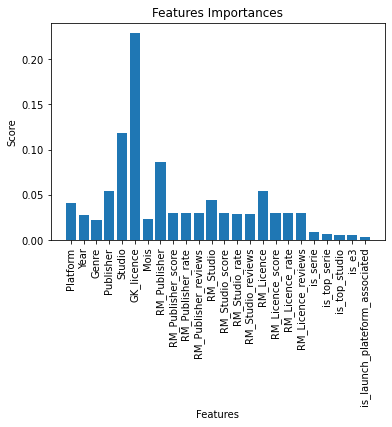

In [104]:
#Affichage des features ayant le plus influcées le modèle
import matplotlib.pyplot as plt
plt.bar(X_train.columns, rfc_grid.feature_importances_)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Score")
plt.title("Features Importances");

# 6 catégories
Le même code a été appliqué mais sur 6 catégories au lieu de 4

In [140]:
df_rm_tosplit2 = df_rm

In [141]:
#Création des 6 catégories de vente, suppression des variables inutiles et labélisation des variables catégorielles
df_rm_tosplit2['Sales_cat'] = pd.cut(df_rm_tosplit2['Global_Sales'], bins=[0,0.1,0.249,0.499, 0.999, 5, 100000], 
       labels=[1,2,3,4,5,6])
df_rm_tosplit2['Sales_cat'] = df_rm_tosplit2['Sales_cat'].astype("int")
df_rm_tosplit2 = df_rm_tosplit2.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)

cat_cols = df_rm_tosplit2.select_dtypes(include=['object']).columns.to_list()
for col in cat_cols:
    i = 1
    occurences = df_rm_tosplit2[col].unique()
    for occ in occurences:
        df_rm_tosplit2.loc[df_rm_tosplit2[col]==occ, col] = i
        i+=1
        
df_rm_tosplit2[cat_cols] = df_rm_tosplit2[cat_cols].astype('float')
df_rm_tosplit2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16538 entries, 0 to 16537
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Platform                        16538 non-null  float64       
 1   Year                            16538 non-null  float64       
 2   Genre                           16538 non-null  float64       
 3   Publisher                       16538 non-null  float64       
 4   Studio                          16538 non-null  float64       
 5   GK_licence                      16538 non-null  float64       
 6   Mois                            16538 non-null  float64       
 7   Date_Sortie                     16538 non-null  datetime64[ns]
 8   RM_Publisher                    16516 non-null  float64       
 9   RM_Publisher_score              14347 non-null  float64       
 10  RM_Publisher_rate               14347 non-null  float64       
 11  RM

In [142]:
#Gestion des NaNs sur les moyennes mobiles des notes joueurs par la moyenne des moyennes mobiles antérieures
rm_publisher_score=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Publisher_score"]):
    if str(rm)=="nan":
        rm_publisher_score.append(df_rm_tosplit2["RM_Publisher_score"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_publisher_score.append(rm)
        

rm_studio_score=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Studio_score"]):
    if str(rm)=="nan":
        rm_studio_score.append(df_rm_tosplit2["RM_Studio_score"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_studio_score.append(rm)
        
rm_licence_score=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Licence_score"]):
    if str(rm)=="nan":
        rm_licence_score.append(df_rm_tosplit2["RM_Licence_score"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_licence_score.append(rm)
        
df_rm_tosplit2["RM_Publisher_score"]=rm_publisher_score
df_rm_tosplit2["RM_Studio_score"]=rm_studio_score
df_rm_tosplit2["RM_Licence_score"]=rm_licence_score

In [143]:
#Gestion des NaNs sur les moyennes mobiles des notes journalistes par la moyenne des moyennes mobiles antérieures
rm_publisher_rate=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Publisher_rate"]):
    if str(rm)=="nan":
        rm_publisher_rate.append(df_rm_tosplit2["RM_Publisher_rate"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_publisher_rate.append(rm)
        

rm_studio_rate=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Studio_rate"]):
    if str(rm)=="nan":
        rm_studio_rate.append(df_rm_tosplit2["RM_Studio_rate"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_studio_rate.append(rm)
        
rm_licence_rate=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Licence_rate"]):
    if str(rm)=="nan":
        rm_licence_rate.append(df_rm_tosplit2["RM_Licence_rate"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_licence_rate.append(rm)
        
df_rm_tosplit2["RM_Publisher_rate"]=rm_publisher_rate
df_rm_tosplit2["RM_Studio_rate"]=rm_studio_rate
df_rm_tosplit2["RM_Licence_rate"]=rm_licence_rate

In [144]:
#Gestion des NaNs sur les moyennes mobiles du nombre d'avis par la moyenne des moyennes mobiles antérieures
rm_publisher_review=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Publisher_reviews"]):
    if str(rm)=="nan":
        rm_publisher_review.append(df_rm_tosplit2["RM_Publisher_reviews"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_publisher_review.append(rm)
        

rm_studio_review=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Studio_reviews"]):
    if str(rm)=="nan":
        rm_studio_review.append(df_rm_tosplit2["RM_Studio_reviews"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_studio_review.append(rm)
        
rm_licence_review=[]
for date,rm in zip(df_rm_tosplit2["Date_Sortie"],df_rm_tosplit2["RM_Licence_reviews"]):
    if str(rm)=="nan":
        rm_licence_review.append(df_rm_tosplit2["RM_Licence_reviews"][df_rm_tosplit2["Date_Sortie"]<date].mean())
    else:
        rm_licence_review.append(rm)
        
df_rm_tosplit2["RM_Publisher_reviews"]=rm_publisher_review
df_rm_tosplit2["RM_Studio_reviews"]=rm_studio_review
df_rm_tosplit2["RM_Licence_reviews"]=rm_licence_review

In [145]:
#Vérification des NaNs
df_rm_tosplit2.isna().sum()

Platform                           0
Year                               0
Genre                              0
Publisher                          0
Studio                             0
GK_licence                         0
Mois                               0
Date_Sortie                        0
RM_Publisher                      22
RM_Publisher_score                 5
RM_Publisher_rate                  5
RM_Publisher_reviews               5
RM_Studio                         22
RM_Studio_score                    5
RM_Studio_rate                     5
RM_Studio_reviews                  5
RM_Licence                        22
RM_Licence_score                   5
RM_Licence_rate                    5
RM_Licence_reviews                 5
is_serie                           0
is_top_serie                       0
is_top_studio                      0
is_e3                              0
is_launch_plateform_associated     0
Sales_cat                          0
dtype: int64

In [146]:
#Suppression des NaNs restants
df_rm_tosplit2=df_rm_tosplit2.dropna()

In [147]:
#Vérification des NaNs
df_rm_tosplit2.isna().sum()

Platform                          0
Year                              0
Genre                             0
Publisher                         0
Studio                            0
GK_licence                        0
Mois                              0
Date_Sortie                       0
RM_Publisher                      0
RM_Publisher_score                0
RM_Publisher_rate                 0
RM_Publisher_reviews              0
RM_Studio                         0
RM_Studio_score                   0
RM_Studio_rate                    0
RM_Studio_reviews                 0
RM_Licence                        0
RM_Licence_score                  0
RM_Licence_rate                   0
RM_Licence_reviews                0
is_serie                          0
is_top_serie                      0
is_top_studio                     0
is_e3                             0
is_launch_plateform_associated    0
Sales_cat                         0
dtype: int64

In [148]:
#Suppression de la date de lancement des jeux
df_rm_tosplit2=df_rm_tosplit2.drop("Date_Sortie",axis=1)

In [150]:
#Split du dataset en groupe d'entraitement et groupe de test
target=df_rm_tosplit2["Sales_cat"]
data=df_rm_tosplit2.drop("Sales_cat",axis=1)

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2)

In [151]:
#Affichage du nombre de jeux par catégorie dans le groupe d'entrainement
y_train.value_counts()

1    4901
2    2870
3    2211
4    1544
5    1516
6     166
Name: Sales_cat, dtype: int64

In [153]:
#Instanciation, prédictions et évaluations de plusieurs modèles pour identifier le plus performant

knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_test=knn.predict(X_test)
metric_eval_knn=compute_score(y_test,y_pred_test)
print(" KNN compute score :" , metric_eval_knn)
print(" KNN score :" , knn.score(X_test,y_test))

rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_test=rfc.predict(X_test)
metric_eval_rfc=compute_score(y_test,y_pred_test)
print(" RF compute score" , metric_eval_rfc)
print(" RF score :" , rfc.score(X_test,y_test))

dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test=dt.predict(X_test)
metric_eval_dt=compute_score(y_test,y_pred_test)
print(" DT compute score" , metric_eval_dt)
print(" DT score :" , dt.score(X_test,y_test))

lg=LogisticRegression(max_iter=1000,class_weight="balanced")
lg.fit(X_train,y_train)
y_pred_test=lg.predict(X_test)
metric_eval_lg=compute_score(y_test,y_pred_test)
print(" LG compute score" , metric_eval_lg)
print(" LG score :" , lg.score(X_test,y_test))

 KNN compute score : 0.2471490564133616
 KNN score : 0.547683923705722
 RF compute score 0.17317590069633668
 RF score : 0.6657584014532243
 DT compute score 0.2176808961550106
 DT score : 0.5885558583106267
 LG compute score 0.26410334039761835
 LG score : 0.48077505298213746


Le modèle Random Forest reste le plus performant même sur 6 catégories de ventes

In [154]:
#GridSearch pour trouver les meilleurs hyperparamètres
param_rf=[{'criterion': ['gini', 'entropy'],
           'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
           'max_features': ['auto', 'sqrt', 'log2']}]

gridcv=GridSearchCV(rfc,param_grid=param_rf,cv=3,scoring=make_scorer(compute_score,greater_is_better=False))
gridcv.fit(X_train,y_train)

gridcv.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto'}

In [155]:
#Réapplication du modèle avec les meilleurs hyperparamètres identifiés
rfc_grid = RandomForestClassifier(
    criterion=gridcv.best_params_['criterion'],
    max_depth=gridcv.best_params_['max_depth'],
    max_features=gridcv.best_params_['max_features'])

rfc_grid.fit(X_train, y_train)
y_pred = rfc_grid.predict(X_test)

In [156]:
#Evaluation du modèle
metric_eval_rfc_grid = compute_score(y_test,y_pred)
print(" RF compute score" , metric_eval_rfc_grid)
print(" RF_grid score :" , rfc_grid.score(X_test,y_test))

 RF compute score 0.17357957412453326
 RF_grid score : 0.6754465637299425


In [157]:
#Affichage de la matrice de corrélation
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2,3,4,5,6
Classe réelle,,,,,,
1,1013,106,64,18,38,0
2,111,480,108,31,27,1
3,63,60,301,49,51,0
4,35,30,52,175,93,0
5,21,16,32,32,251,6
6,0,1,1,0,26,11


In [158]:
#Affichage du rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.82      0.82      1239
           2       0.69      0.63      0.66       758
           3       0.54      0.57      0.56       524
           4       0.57      0.45      0.51       385
           5       0.52      0.70      0.59       358
           6       0.61      0.28      0.39        39

    accuracy                           0.68      3303
   macro avg       0.62      0.58      0.59      3303
weighted avg       0.68      0.68      0.67      3303



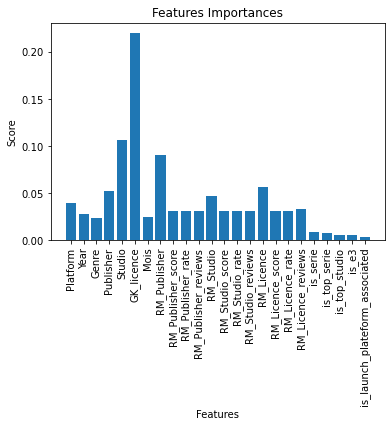

In [159]:
#Affichage des features avec le plus d'influence sur le modèle
import matplotlib.pyplot as plt
plt.bar(X_train.columns, rfc_grid.feature_importances_)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Score")
plt.title("Features Importances");